Question 1

In [1]:
import time
import random
import matplotlib.pyplot as plt

class QuadTreeNode:
    def __init__(self, bounds, points):
        self.bounds = bounds
        self.points = points
        self.children = []
        self.representative_point = None
        self.active = True

class QuadTree:
    def __init__(self, points, dimension, threshold=2, representative_method="centroid"):
        """
        Initialize the QuadTree.

        :param points: List of d-dimensional points.
        :param dimension: Dimensionality of the points (d).
        :param threshold: Maximum number of points in a leaf node.
        :param representative_method: Method to choose representative points (centroid, median, first_point).
        """
        self.dimension = dimension
        self.threshold = threshold
        self.representative_method = representative_method
        self.root = self._build_tree(points, self._get_bounds(points))
        self.construction_time = None
        self.points = points

    def _get_bounds(self, points):
        """Compute the bounds (min, max) for each dimension."""
        return [(min([p[i] for p in points]), max([p[i] for p in points])) for i in range(self.dimension)]

    def _is_in_bounds(self, point, bounds):
        """Check if a point lies within the bounds."""
        return all(bounds[i][0] <= point[i] <= bounds[i][1] for i in range(len(bounds)))

    def _subdivide(self, bounds):
        """
        Subdivide the given bounds into 2^d sub-regions.
        Returns a list of new bounds for each sub-region.
        """
        midpoints = [(min_v + max_v) / 2 for min_v, max_v in bounds]
        subregions = []

        for mask in range(1 << self.dimension):
            subregion = []
            for i in range(self.dimension):
                if mask & (1 << i):
                    subregion.append((midpoints[i], bounds[i][1]))
                else:
                    subregion.append((bounds[i][0], midpoints[i]))
            subregions.append(subregion)
        return subregions

    def _choose_representative(self, points, method):
        """Choose the representative point based on the specified method."""
        if method == "centroid":
            return [sum(p[i] for p in points) / len(points) for i in range(self.dimension)]
        elif method == "median":
            return [sorted(p[i] for p in points)[len(points) // 2] for i in range(self.dimension)]
        elif method == "first_point":
            return points[0]
        else:
            raise ValueError(f"Invalid representative method: {method}")

    def _build_tree(self, points, bounds):
        """Recursively build the QuadTree."""
        if len(points) <= self.threshold:
            node = QuadTreeNode(bounds, points)
            node.representative_point = self._choose_representative(points, self.representative_method)
            return node

        subregions = self._subdivide(bounds)
        children = []
        for subregion in subregions:
            child_points = [p for p in points if self._is_in_bounds(p, subregion)]
            if child_points:
                children.append(self._build_tree(child_points, subregion))

        node = QuadTreeNode(bounds, [])
        node.children = children
        node.representative_point = self._choose_representative(points, self.representative_method)
        return node

    def construct_tree(self, points):
        """Construct the tree and measure the time."""
        start_time = time.time()
        self.root = self._build_tree(points, self._get_bounds(points))
        self.construction_time = time.time() - start_time
        print(f"Tree constructed in {self.construction_time:.4f} seconds.")

    def compute_tree_height(self, node=None):
        """Compute the height of the tree."""
        if node is None:
            node = self.root
        if not node.children:
            return 1
        return 1 + max(self.compute_tree_height(child) for child in node.children)

    def compute_simple_spread(self):
        """Compute the spread of the dataset."""
        return max(max_v - min_v for min_v, max_v in self.root.bounds)

    def compute_rigorous_spread(self):
        """
        Compute the spread as the ratio of:
        Maximum distance between any two points
        to the minimum distance between any two points.
        """
        max_distance = float('-inf')
        min_distance = float('inf')

        for i in range(len(self.points)):
            for j in range(i + 1, len(self.points)):
                dist = sum((self.points[i][k] - self.points[j][k])**2 for k in range(self.dimension))**0.5
                max_distance = max(max_distance, dist)
                min_distance = min(min_distance, dist)

        if min_distance == 0:
            raise ValueError("Minimum distance is zero; rigorous spread is undefined for identical points.")

        return max_distance / min_distance


def parse_dataset(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    dimension = int(lines[0].strip())
    points = [tuple(map(float, line.strip().split(','))) for line in lines[1:]]
    return dimension, points



if __name__ == "__main__":

    file_path = "dataset.txt"
    dimension, points = parse_dataset(file_path)
    quad_tree = QuadTree(points, dimension, threshold=2, representative_method="centroid")
    quad_tree.construct_tree(points)
    tree_height = quad_tree.compute_tree_height()
    simple_spread = quad_tree.compute_simple_spread()
    rigorous_spread = quad_tree.compute_rigorous_spread()

    print(f"Tree Height: {tree_height}")
    print(f"Simple spread of the dataset: {simple_spread}")
    print(f"Rigorous spread of the dataset: {rigorous_spread}")


Tree constructed in 1.6503 seconds.
Tree Height: 11
Simple spread of the dataset: 999.7600000000001
Rigorous spread of the dataset: 15550.613705736101


Question 2

Tree constructed in 0.3057 seconds.


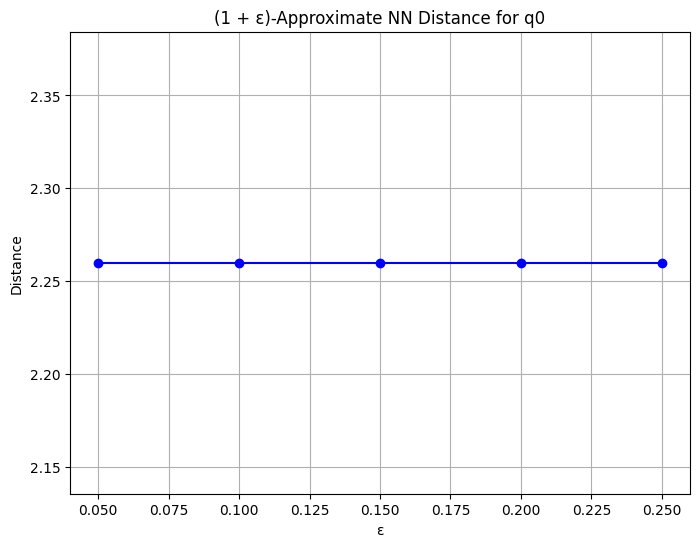

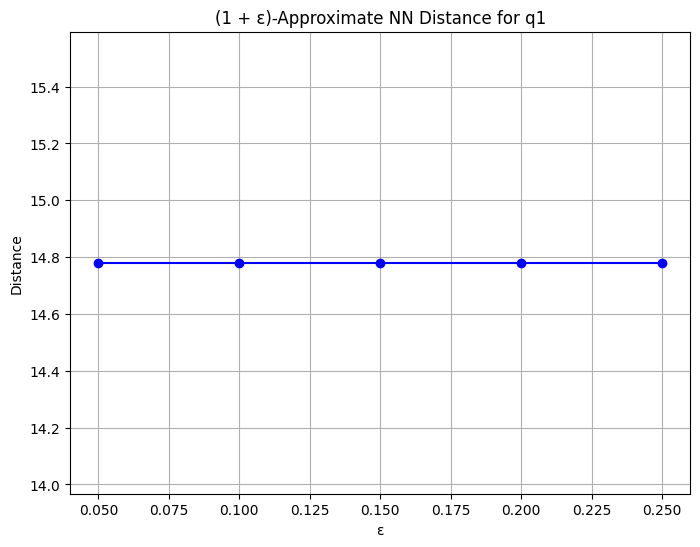

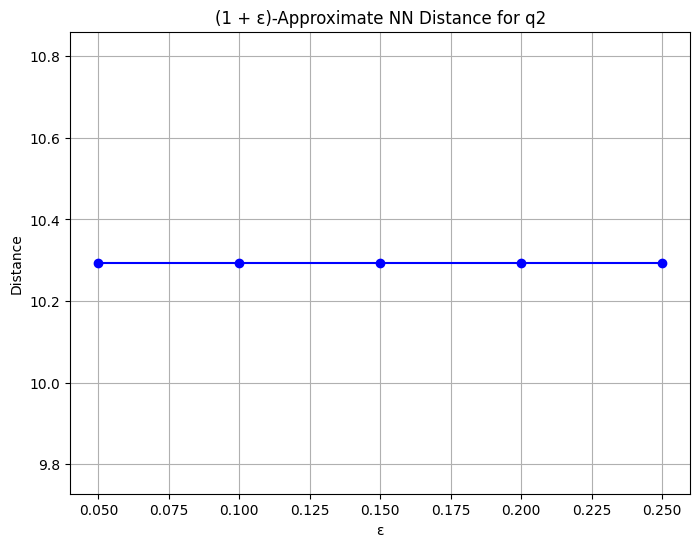

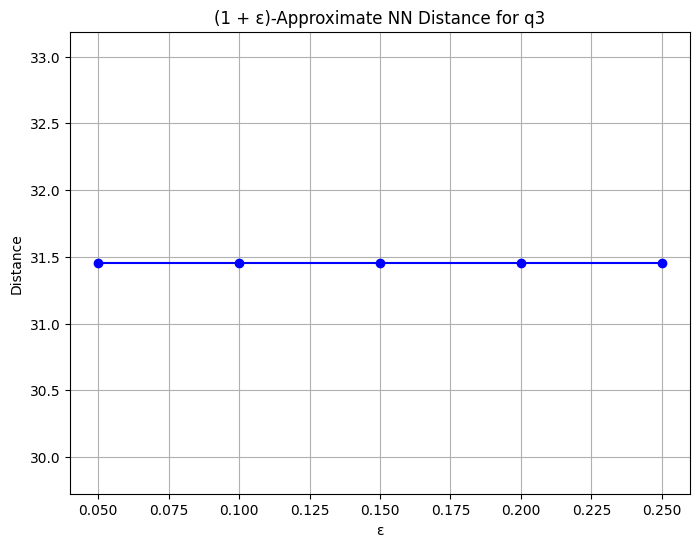

Box1 - Avg Query Time: 0.003070s, Avg Distance: 4.9412
Box2 - Avg Query Time: 0.012710s, Avg Distance: 384.7868


In [2]:
class QuadTreeEnhanced(QuadTree):
    def approximate_nearest_neighbor(self, query_point, epsilon):
        best_point = None
        best_distance = float('inf')

        def search(node):
            nonlocal best_point, best_distance
            if not node.children:
                for point in node.points:
                    dist = sum((point[i] - query_point[i]) ** 2 for i in range(self.dimension)) ** 0.5
                    if dist < best_distance:
                        best_distance = dist
                        best_point = point
                return
            for child in node.children:
                if child:
                    child_distance = sum(
                        max(0, bounds[0] - query_point[i], query_point[i] - bounds[1]) ** 2
                        for i, bounds in enumerate(child.bounds)
                    ) ** 0.5
                    if child_distance <= (1 + epsilon) * best_distance:
                        search(child)

        search(self.root)
        return best_point, best_distance


def parse_dataset(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    dimension = int(lines[0].strip())
    points = [tuple(map(float, line.strip().split(','))) for line in lines[1:]]
    return dimension, points


def plot_epsilon_vs_distance(query_results, query_label):
    plt.figure(figsize=(8, 6))
    plt.plot(query_results.keys(), query_results.values(), marker='o', linestyle='-', color='blue')
    plt.title(f"(1 + ε)-Approximate NN Distance for {query_label}")
    plt.xlabel("ε")
    plt.ylabel("Distance")
    plt.grid()
    plt.show()


file_path = "dataset.txt"
dimension, points = parse_dataset(file_path)
quad_tree = QuadTreeEnhanced(points, dimension, threshold=5, representative_method="median")
quad_tree.construct_tree(points)
epsilon_values = [0.05, 0.1, 0.15, 0.2, 0.25]
queries = {
    "q0": [500, 500],
    "q1": [1000, 1000],
    "q2": [30, 950],
    "q3": [0, 1020]
}

for query_label, query_point in queries.items():
    query_results = {}
    for epsilon in epsilon_values:
        _, distance = quad_tree.approximate_nearest_neighbor(query_point, epsilon)
        query_results[epsilon] = distance
    plot_epsilon_vs_distance(query_results, query_label)

for box_label, box_range in [("Box1", [0, 1000]), ("Box2", [1000, 1500])]:
    start_time = time.time()
    distances = []
    for _ in range(1000):
        random_query = [random.uniform(*box_range) for _ in range(dimension)]
        _, distance = quad_tree.approximate_nearest_neighbor(random_query, epsilon=0.1)
        distances.append(distance)
    avg_time = (time.time() - start_time) / 1000
    avg_distance = sum(distances) / len(distances)
    print(f"{box_label} - Avg Query Time: {avg_time:.6f}s, Avg Distance: {avg_distance:.4f}")


Question 3

Box 1 - Avg Deletion Time: 0.032429s


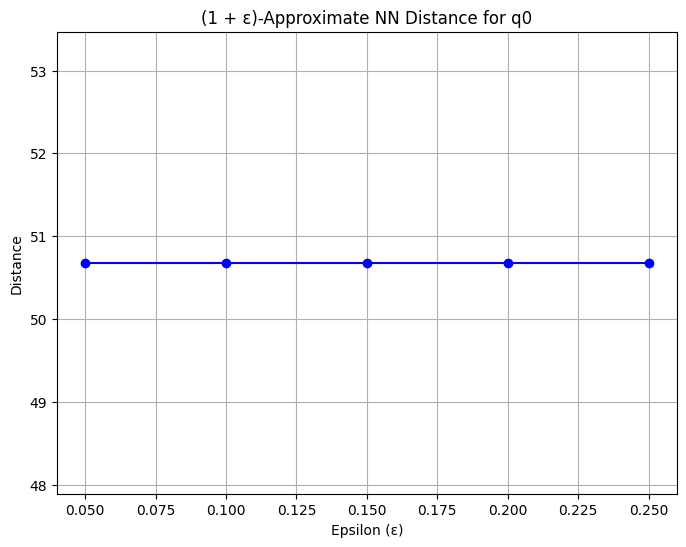

Box 2 - Avg Deletion Time: 0.041646s


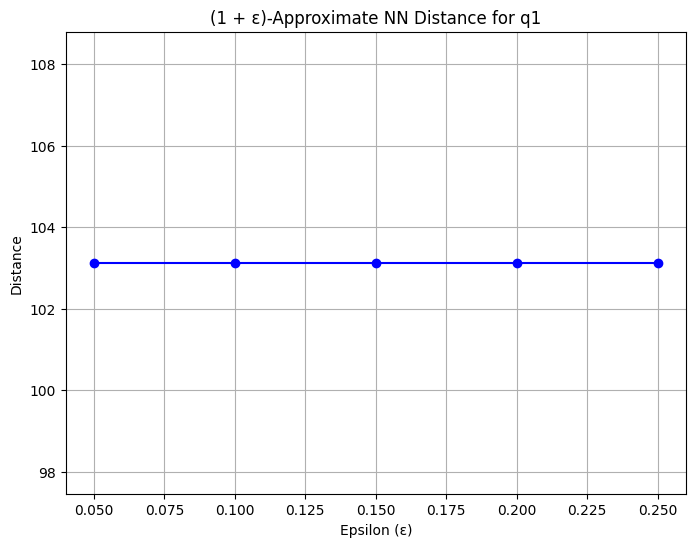

Avg Deletion Time: 0.015154s


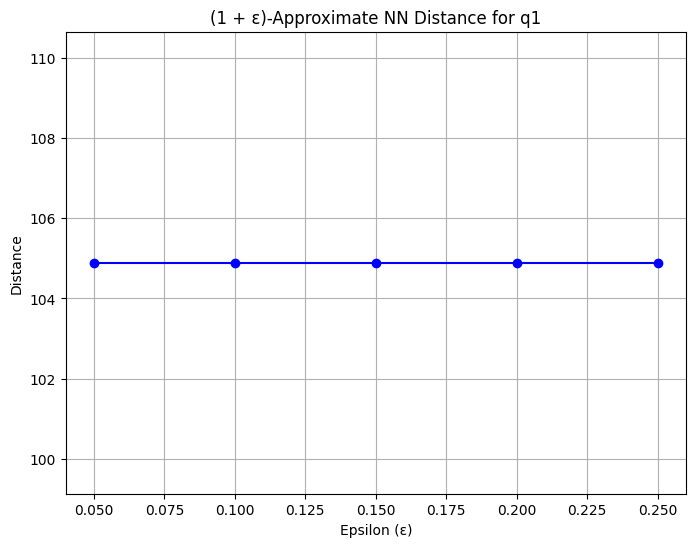

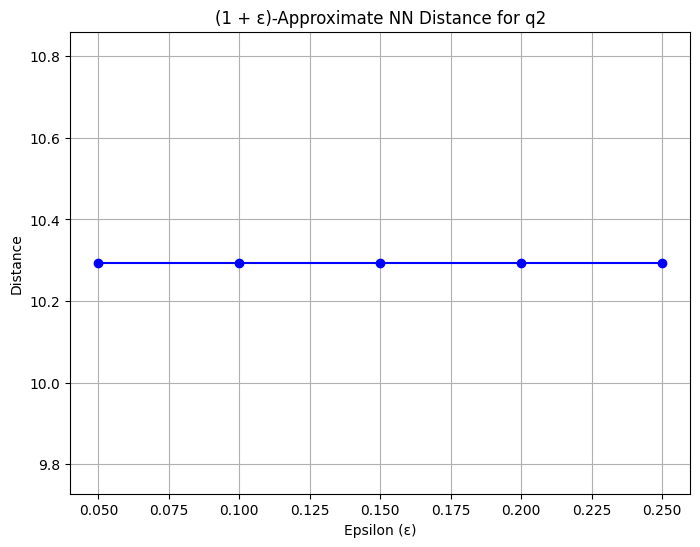

Remaining Points In The Tree are 4000
Box1 - Avg Query Time: 0.001555s, Avg Distance: 8.5686
Box2 - Avg Query Time: 0.006561s, Avg Distance: 441.3871


In [3]:
class QuadTreeEnhanced(QuadTree):
    def __init__(self, points, dimension, threshold=1, representative_method="centroid"):
        super().__init__(points, dimension, threshold, representative_method)

    def delete_point(self, point):
        def search_and_delete(node):
            if not node.children:
                if point in node.points:
                    node.points.remove(point)
                    if not node.points:
                        node.active = False
                    return True
                return False
            deleted = False
            for child in node.children:
                if search_and_delete(child):
                    deleted = True
            if deleted:
                node.representative_point = self._choose_representative(self.points, self.representative_method)
            return deleted
        search_and_delete(self.root)

    def rebuild_tree(self, points, dimension, threshold, representative_method):
        return QuadTreeEnhanced(points, dimension, threshold, representative_method)

    def approximate_nearest_neighbor(self, query_point, epsilon):
        best_point = None
        best_distance = float('inf')

        def search(node):
            nonlocal best_point, best_distance
            if not node.active:
                return
            if not node.children:
                for p in node.points:
                    dist = sum((p[i] - query_point[i]) ** 2 for i in range(self.dimension)) ** 0.5
                    if dist < best_distance:
                        best_distance = dist
                        best_point = p
                return
            for child in node.children:
                if child:
                    child_distance = sum(
                        max(0, bounds[0] - query_point[i], query_point[i] - bounds[1]) ** 2
                        for i, bounds in enumerate(child.bounds)
                    ) ** 0.5
                    if child_distance <= (1 + epsilon) * best_distance:
                        search(child)

        search(self.root)
        return best_point, best_distance

def randomly_delete_points(quad_tree, remaining_points, num_to_delete):
    points_to_delete = random.sample(remaining_points, min(num_to_delete, len(remaining_points)))
    start_time = time.time()
    for point in points_to_delete:
        quad_tree.delete_point(point)
        remaining_points.remove(point)

    avg_deletion_time = (time.time() - start_time) / len(points_to_delete)
    return avg_deletion_time, remaining_points

def calculate_points_to_trigger_reconstruction(total_points, remaining_points):
    target_remaining = total_points // 2
    return remaining_points - target_remaining

def run_deletions_and_reconstruction(quad_tree, N, points, dimension, box, threshold, representative_method):
    remaining_points = points.copy()
    points_to_delete = [p for p in remaining_points if all(box[0] <= p[i] <= box[1] for i in range(dimension))]
    total_points = N

    start_time = time.time()
    for point in points_to_delete:
        quad_tree.delete_point(point)
        remaining_points.remove(point)

        if len(remaining_points) <= (total_points / 2):
            quad_tree = quad_tree.rebuild_tree(remaining_points)
            triggered_reconstruction = True

    avg_deletion_time = (time.time() - start_time) / len(points_to_delete)
    return quad_tree, avg_deletion_time, remaining_points

def visualize_results(queries, epsilon_values, quad_tree):
    for query_label, query_point in queries.items():
        query_results = {}
        for epsilon in epsilon_values:
            _, distance = quad_tree.approximate_nearest_neighbor(query_point, epsilon)
            query_results[epsilon] = distance
        plt.figure(figsize=(8, 6))
        plt.plot(query_results.keys(), query_results.values(), marker='o', linestyle='-', color='blue')
        plt.title(f"(1 + ε)-Approximate NN Distance for {query_label}")
        plt.xlabel("Epsilon (ε)")
        plt.ylabel("Distance")
        plt.grid()
        plt.show()


def parse_dataset(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    dimension = int(lines[0].strip())
    points = [tuple(map(float, line.strip().split(','))) for line in lines[1:]]
    return dimension, points




triggered_reconstruction = False
file_path = "dataset.txt"
dimension, points = parse_dataset(file_path)
N = len(points)
quad_tree = QuadTreeEnhanced(points, dimension, threshold=5, representative_method="median")


box_1 = [450, 550]
quad_tree, avg_time_1, remaining_points = run_deletions_and_reconstruction(quad_tree, N, points, dimension, box_1, threshold=5, representative_method="median")
print(f"Box 1 - Avg Deletion Time: {avg_time_1:.6f}s")
queries = {
    "q0": [500, 500]
}
epsilon_values = [0.05, 0.1, 0.15, 0.2, 0.25]
visualize_results(queries, epsilon_values, quad_tree)



box_2 = [900, 1000]
quad_tree, avg_time_2, remaining_points = run_deletions_and_reconstruction(quad_tree, N, remaining_points, dimension, box_2, threshold=5, representative_method="median")
print(f"Box 2 - Avg Deletion Time: {avg_time_2:.6f}s")
queries = {
    "q1": [1000, 1000]
}
epsilon_values = [0.05, 0.1, 0.15, 0.2, 0.25]
visualize_results(queries, epsilon_values, quad_tree)



if not triggered_reconstruction:
  num_to_delete = calculate_points_to_trigger_reconstruction(len(points), len(remaining_points))
  _, remaining_points = randomly_delete_points(quad_tree, remaining_points, num_to_delete)
  quad_tree = QuadTreeEnhanced(remaining_points, dimension, threshold=5, representative_method="median")
num_to_delete = 1000
avg_time_3, remaining_points = randomly_delete_points(quad_tree, remaining_points, num_to_delete)
print(f"Avg Deletion Time: {avg_time_3:.6f}s")
queries = {
    "q1": [1000, 1000],
    "q2": [30, 950]
}
epsilon_values = [0.05, 0.1, 0.15, 0.2, 0.25]
visualize_results(queries, epsilon_values, quad_tree)
print("Remaining Points In The Tree are", len(remaining_points))


for box_label, box_range in [("Box1", [0, 1000]), ("Box2", [1000, 1500])]:
    start_time = time.time()
    distances = []
    for _ in range(1000):
        random_query = [random.uniform(*box_range) for _ in range(dimension)]
        _, distance = quad_tree.approximate_nearest_neighbor(random_query, epsilon=0.1)
        distances.append(distance)
    avg_time = (time.time() - start_time) / 1000
    avg_distance = sum(distances) / len(distances)
    print(f"{box_label} - Avg Query Time: {avg_time:.6f}s, Avg Distance: {avg_distance:.4f}")


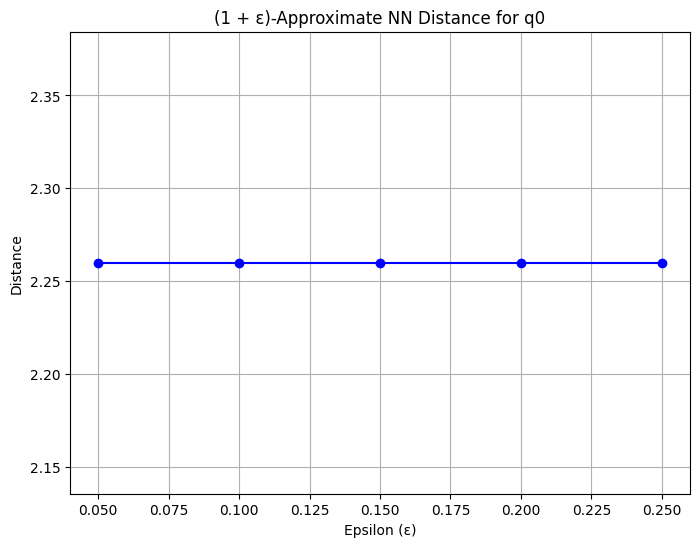

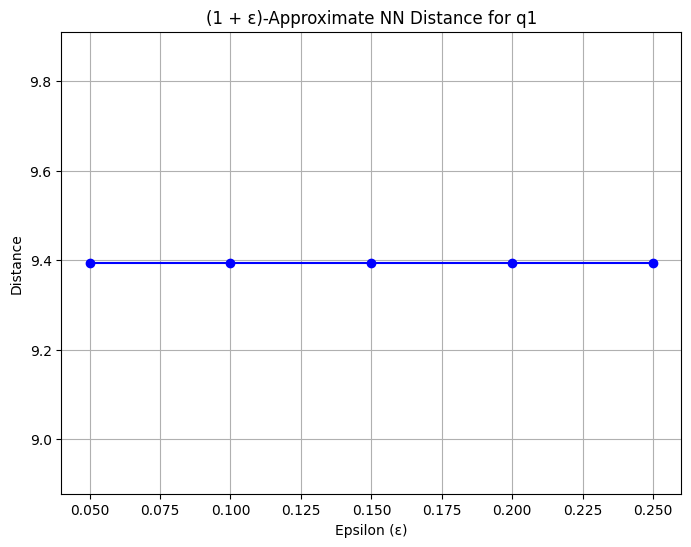

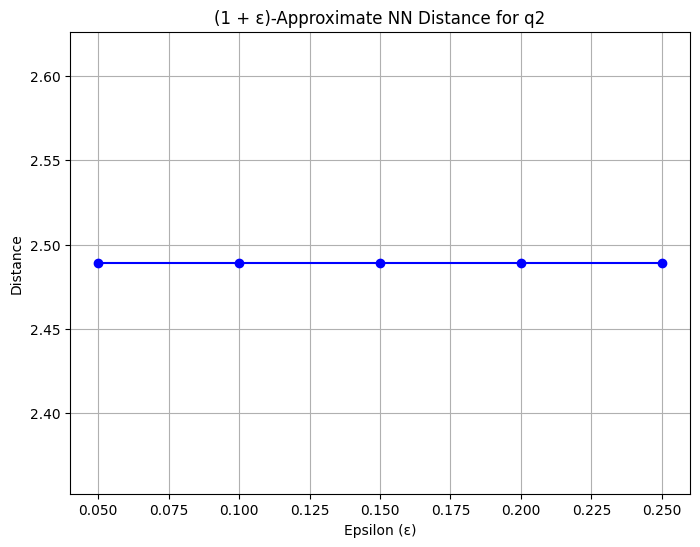

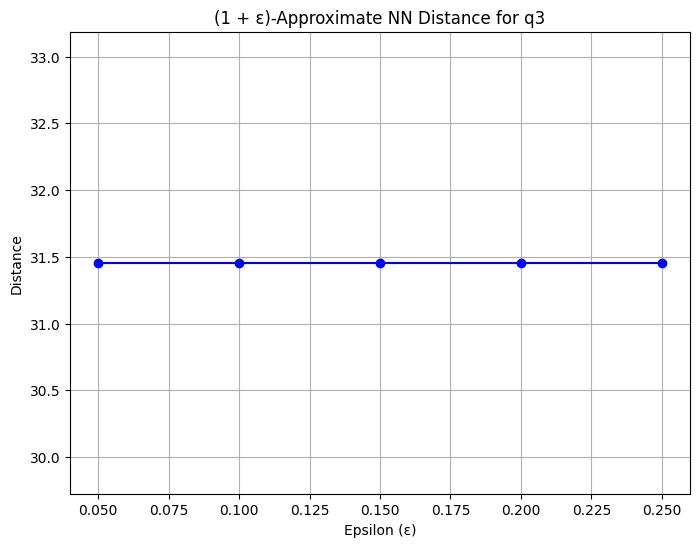

Box1 - Avg Query Time: 0.004985s, Avg Distance: 4.1905
Box1 - Avg Query Time: 0.021255s, Avg Distance: 385.3037
Box1 - Avg Query Time: 0.024736s, Avg Distance: 761.2472
Box2 - Avg Query Time: 0.024864s, Avg Distance: 767.1448


In [4]:
class QuadTreeEnhanced(QuadTree):
    def __init__(self, points, dimension, threshold=1, representative_method="centroid"):
        super().__init__(points, dimension, threshold, representative_method)

    def delete_point(self, point):
        def search_and_delete(node):
            if not node.children:
                if point in node.points:
                    node.points.remove(point)
                    if not node.points:
                        node.active = False
                    return True
                return False
            deleted = False
            for child in node.children:
                if search_and_delete(child):
                    deleted = True
            if deleted:
                node.representative_point = self._choose_representative(self.points, self.representative_method)
            return deleted
        search_and_delete(self.root)

    def insert_point(self, point):
        def insert_into_node(node, point):
            if not node.children:
                node.points.append(point)
                if len(node.points) > self.threshold:
                    bounds = node.bounds
                    subregions = self._subdivide(bounds)
                    node.children = [QuadTreeNode(subregion, []) for subregion in subregions]
                    for p in node.points:
                        for child in node.children:
                            if self._is_in_bounds(p, child.bounds):
                                child.points.append(p)
                                break
                    node.points = []
            else:
                for child in node.children:
                    if self._is_in_bounds(point, child.bounds):
                        insert_into_node(child, point)
                        break

        insert_into_node(self.root, point)

    def approximate_nearest_neighbor(self, query_point, epsilon):
        best_point = None
        best_distance = float('inf')

        def search(node):
            nonlocal best_point, best_distance
            if not node.active:
                return
            if not node.children:
                for p in node.points:
                    dist = sum((p[i] - query_point[i]) ** 2 for i in range(self.dimension)) ** 0.5
                    if dist < best_distance:
                        best_distance = dist
                        best_point = p
                return
            for child in node.children:
                if child:
                    child_distance = sum(
                        max(0, bounds[0] - query_point[i], query_point[i] - bounds[1]) ** 2
                        for i, bounds in enumerate(child.bounds)
                    ) ** 0.5
                    if child_distance <= (1 + epsilon) * best_distance:
                        search(child)

        search(self.root)
        return best_point, best_distance

def randomly_delete_points(quad_tree, remaining_points, num_to_delete):
    points_to_delete = random.sample(remaining_points, min(num_to_delete, len(remaining_points)))
    start_time = time.time()
    for point in points_to_delete:
        quad_tree.delete_point(point)
        remaining_points.remove(point)

    avg_deletion_time = (time.time() - start_time) / len(points_to_delete)
    return avg_deletion_time, remaining_points

def calculate_points_to_trigger_reconstruction(total_points, remaining_points):
    target_remaining = total_points // 2
    return remaining_points - target_remaining

def run_deletions_and_reconstruction(quad_tree, N, points, dimension, box, threshold, representative_method):
    remaining_points = points.copy()
    points_to_delete = [p for p in remaining_points if all(box[0] <= p[i] <= box[1] for i in range(dimension))]
    total_points = N

    start_time = time.time()
    for point in points_to_delete:
        quad_tree.delete_point(point)
        remaining_points.remove(point)

        if len(remaining_points) <= (total_points / 2):
            quad_tree = quad_tree.rebuild_tree(remaining_points)
            triggered_reconstruction = True

    avg_deletion_time = (time.time() - start_time) / len(points_to_delete)
    return quad_tree, avg_deletion_time, remaining_points

def visualize_results(queries, epsilon_values, quad_tree):
    for query_label, query_point in queries.items():
        query_results = {}
        for epsilon in epsilon_values:
            _, distance = quad_tree.approximate_nearest_neighbor(query_point, epsilon)
            query_results[epsilon] = distance
        plt.figure(figsize=(8, 6))
        plt.plot(query_results.keys(), query_results.values(), marker='o', linestyle='-', color='blue')
        plt.title(f"(1 + ε)-Approximate NN Distance for {query_label}")
        plt.xlabel("Epsilon (ε)")
        plt.ylabel("Distance")
        plt.grid()
        plt.show()


def parse_dataset(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    dimension = int(lines[0].strip())
    points = [tuple(map(float, line.strip().split(','))) for line in lines[1:]]
    return dimension, points

file_path = "dataset.txt"
dimension, points = parse_dataset(file_path)
quad_tree = QuadTreeEnhanced(points, dimension, threshold=5, representative_method="median")

random_points = [(random.uniform(0, 1000), random.uniform(0, 1000)) for _ in range(6000)]
for point in random_points:
    quad_tree.insert_point(point)

queries = {
    "q0": [500, 500],
    "q1": [1000, 1000],
    "q2": [30, 950],
    "q3": [0, 1020]
}
epsilon_values = [0.05, 0.1, 0.15, 0.2, 0.25]
visualize_results(queries, epsilon_values, quad_tree)


for box_label, box_range in [("Box1", [0, 1000]),]:
    start_time = time.time()
    distances = []
    for _ in range(1000):
        random_query = [random.uniform(*box_range) for _ in range(dimension)]
        _, distance = quad_tree.approximate_nearest_neighbor(random_query, epsilon=0.1)
        distances.append(distance)
    avg_time = (time.time() - start_time) / 1000
    avg_distance = sum(distances) / len(distances)
    print(f"{box_label} - Avg Query Time: {avg_time:.6f}s, Avg Distance: {avg_distance:.4f}")



for box_label, box_range in [("Box1", [1000, 1500]),]:
    start_time = time.time()
    distances = []
    for _ in range(1000):
        random_query = [random.uniform(*box_range) for _ in range(dimension)]
        _, distance = quad_tree.approximate_nearest_neighbor(random_query, epsilon=0.1)
        distances.append(distance)
    avg_time = (time.time() - start_time) / 1000
    avg_distance = sum(distances) / len(distances)
    print(f"{box_label} - Avg Query Time: {avg_time:.6f}s, Avg Distance: {avg_distance:.4f}")



random_points_2 = [(random.uniform(1000, 2000), random.uniform(1000, 2000)) for _ in range(2000)]
for point in random_points_2:
    quad_tree.insert_point(point)

for box_label, box_range in [("Box1", [1000, 2000]), ("Box2", [1000, 2000])]:
    start_time = time.time()
    distances = []
    for _ in range(1000):
        random_query = [random.uniform(*box_range) for _ in range(dimension)]
        _, distance = quad_tree.approximate_nearest_neighbor(random_query, epsilon=0.1)
        distances.append(distance)
    avg_time = (time.time() - start_time) / 1000
    avg_distance = sum(distances) / len(distances)
    print(f"{box_label} - Avg Query Time: {avg_time:.6f}s, Avg Distance: {avg_distance:.4f}")
